# IMPORTS

In [37]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import cv2
from matplotlib import pyplot as plt

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


# APPLICATION: Brain tumour segmentation

We want to apply these techniques to a real life dataset, for which it is relevant to measure epistemic uncertainty.
We will use a classic brain MRI segmentation dataset that can be found at https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
We will solely apply ensembling for two reasons:
- As said in the paper, " ensembling consistently provides more reliable and practically useful uncertainty estimates"
- MC-dropout requires modifying the training step (which is computationally costly), and therefore is risky.

## Dataset and model definition

In order to save compute time, we will only train our model on a tenth of the dataset, this will nonetheless be sufficient.

In [ ]:
class BrainTumorDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_paths = sorted([f for f in glob.glob(os.path.join(self.data_dir, "**", "*.tif"), recursive=True) if "_mask" not in f])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = img_path.replace(".tif", "_mask.tif")

        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = mask / 255.0
        mask = mask[..., None]

        return torch.tensor(image, dtype=torch.float32).permute(2, 0, 1), torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)

dataset = BrainTumorDataset('./data')
# PC isn't that new
small_dataset, _ = random_split(dataset, [int(0.1 * len(dataset)), len(dataset) - int(0.1 * len(dataset))])
dataloader = torch.utils.data.DataLoader(small_dataset, batch_size=16, shuffle=True)

We chose the most commonly used segmentation network for this task: [U-Net](https://fr.wikipedia.org/wiki/U-Net), information about it can be found in the course slides.

In [4]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2, 2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.dec4(torch.cat((self.upconv4(b), e4), dim=1))
        d3 = self.dec3(torch.cat((self.upconv3(d4), e3), dim=1))
        d2 = self.dec2(torch.cat((self.upconv2(d3), e2), dim=1))
        d1 = self.dec1(torch.cat((self.upconv1(d2), e1), dim=1))

        return torch.sigmoid(self.final_conv(d1))


## Training

Ensembing requires us to train several instances of the same model, this is costly. We therefore restrain ourselves to the same number of models used in the paper (8).

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train loop
num_epochs = 20
for i in range(7):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")

    # Save model
    torch.save(model.state_dict(), "unet_brain_tumor"+str(i+1)+".pth")

## Inference

Now comes the part where ensembling shines. We simply run the inference task with each model (once again this is costly, but MRI segmentation is not a time sensitive task).
We then compute the average and standard deviation of the output tensors to get additional information about out predictions.

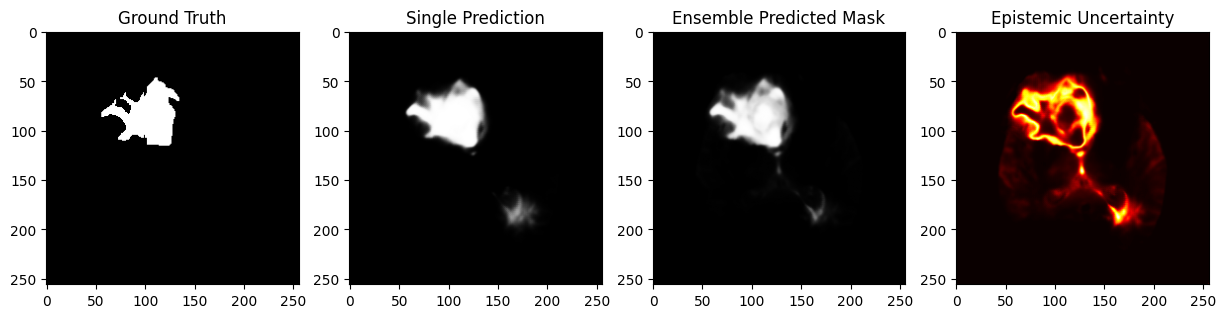

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_paths = ["unet_brain_tumor"+str(i)+".pth" for i in range(8)]
models = []
for path in model_paths:
    model = UNet().to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    models.append(model)

# image
sample_img, sample_mask = dataset[4]
sample_img = sample_img.unsqueeze(0).to(device)


with torch.no_grad():
    pred_masks = []
    for model in models:
        pred_mask = model(sample_img).squeeze(0).cpu().detach()
        pred_masks.append(pred_mask)


pred_masks_tensor = torch.stack(pred_masks)


avg_pred_mask = pred_masks_tensor.mean(dim=0)
uncertainty_map = pred_masks_tensor.std(dim=0) # epistemic uncertainty


sample_img_plot = sample_img.squeeze(0).permute(1, 2, 0).cpu().detach().tolist()
sample_mask_plot = sample_mask.squeeze().cpu().detach().tolist()
single_mask_plot = pred_masks_tensor[3].squeeze().cpu().detach().tolist()
avg_pred_mask_plot = avg_pred_mask.squeeze(0).tolist()
uncertainty_map_plot = uncertainty_map.squeeze(0).tolist()

# PLOT
plt.figure(figsize=(15, 6))

# "Ground truth"
plt.subplot(1, 4, 1)
plt.imshow(sample_mask_plot, cmap="gray")
plt.title("Ground Truth")

# single prediction example
plt.subplot(1, 4, 2)
plt.imshow(single_mask_plot, cmap="gray")
plt.title("Single Prediction")

# mean
plt.subplot(1, 4, 3)
plt.imshow(avg_pred_mask_plot, cmap="gray")
plt.title("Ensemble Predicted Mask")

# std
plt.subplot(1, 4, 4)
plt.imshow(uncertainty_map_plot, cmap="hot")  # 'hot' colormap shows uncertainty levels
plt.title("Epistemic Uncertainty")

plt.show()


This example is quite relevant. Had we simply trained a single model and obtained weights similar to those of our fourth model (second image), it would have been reasonable to suspect the presence of a tumour near the occipital lobe (bottom right of the image). However, our estimation of the epistemic uncertainty (fourth image) reveals that predictions in this area vary greatly from model to model, and are therefore most likely due to variation in the weights.

# CONCLUSION

We did not include any particular scoring, or comparaison with a baseline, since performance isn't what we're going for here. The takeaway is that at when implementing deep learning, it is rather straightforward (although costly) to implement an ensembling scheme, which is a good way to get additional information about our predictions!